# LIBRA and the Liquid Immersion Blanket
## 1L BABY
- Wall permeation
- FLiBe handing (ClLiF)
- Wall materials
- Tritium probe 

In [1]:
import math
import openmc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
import helpers
from openmc_model import baby_model

### Geometry

In [2]:
model = baby_model()
geometry = model.geometry

isotopes ['Al27', 'Ar36', 'Ar38', 'Ar40', 'B10', 'B11', 'Be9', 'C12', 'C13', 'Ca40', 'Ca42', 'Ca43', 'Ca44', 'Ca46', 'Ca48', 'Cl35', 'Cl37', 'Co59', 'Cr50', 'Cr52', 'Cr53', 'Cr54', 'Cu63', 'Cu65', 'F19', 'Fe54', 'Fe56', 'Fe57', 'Fe58', 'H1', 'H2', 'He3', 'He4', 'K39', 'K40', 'K41', 'Li6', 'Li7', 'Mg24', 'Mg25', 'Mg26', 'Mn55', 'Mo100', 'Mo92', 'Mo94', 'Mo95', 'Mo96', 'Mo97', 'Mo98', 'N14', 'N15', 'Na23', 'Nb93', 'Ni58', 'Ni60', 'Ni61', 'Ni62', 'Ni64', 'O16', 'O17', 'O18', 'P31', 'Pb204', 'Pb206', 'Pb207', 'Pb208', 'S32', 'S33', 'S34', 'S36', 'Si28', 'Si29', 'Si30', 'Ti46', 'Ti47', 'Ti48', 'Ti49', 'Ti50', 'W182', 'W183', 'W184', 'W186', 'Zr90', 'Zr91', 'Zr92', 'Zr94', 'Zr96']
Searching libraries with the following priority {'ENDFB-8.0-NNDC': 1}
Isotopes found matching library requirements 556
Isotopes found matching particle requirements 1789
Isotopes found matching isotope requirements 345
Isotopes found matching all requirements 87
             library remote_file  \
1233  ENDFB-8.0-N

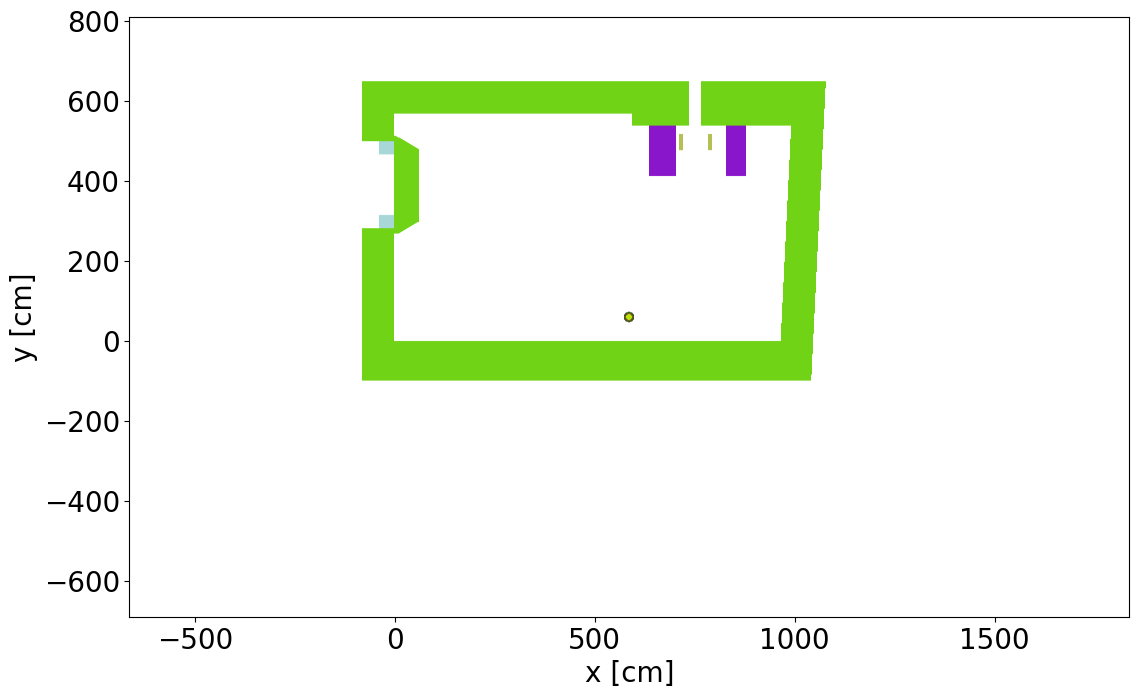

In [3]:
# Visualization

from libra_toolbox.neutronics.vault import Air
from openmc_model import air

x_c = 587
y_c = 60
z_c = 100
ax = geometry.plot(
    width=(2500, 1500),
    origin=(x_c, y_c, z_c + 10),
    pixels=(1000, 1000),
    basis="xy",
    color_by="material",
    colors={Air: "white", air: "white"},
)
ax.tick_params(axis="both", labelsize=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.show()

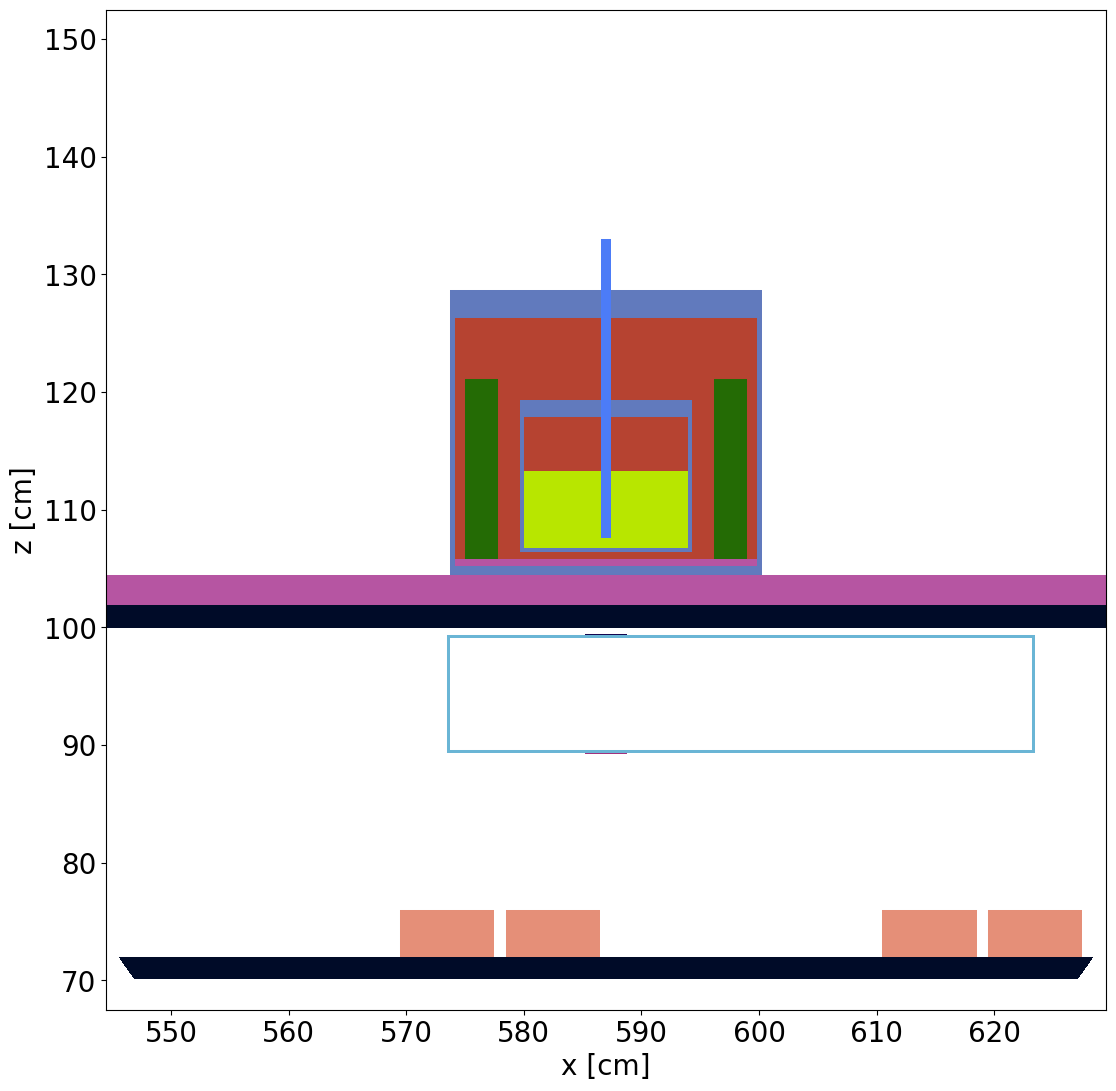

In [4]:
ax = geometry.plot(
    width=(85, 85),
    origin=(x_c, y_c, z_c + 10),
    pixels=(1000, 1000),
    basis="xz",
    color_by="material",
    colors={Air: "white", air: "white"},
)
ax.tick_params(axis="both", labelsize=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.show()

### Result

In [5]:
sp = openmc.StatePoint("statepoint.100.h5")
tbr_withvault = sp.get_tally(name="TBR").get_pandas_dataframe()
print(f"TBR: {tbr_withvault['mean'].sum() :.6e}\n")
print(f"TBR std. dev.: {tbr_withvault['std. dev.'].sum() :.6e}\n")
lithium_6_contribution = tbr_withvault[tbr_withvault['nuclide'] == 'Li6']['mean'].sum()
lithium_7_contribution = tbr_withvault[tbr_withvault['nuclide'] == 'Li7']['mean'].sum()
print(f"The tritium breeding by lithium 6 is: {lithium_6_contribution :.6e}")
print(f"The tritium breeding by lithium 7 is: {lithium_7_contribution :.6e}")

TBR: 2.024625e-03

TBR std. dev.: 3.094356e-05

The tritium breeding by lithium 6 is: 6.718903e-04
The tritium breeding by lithium 7 is: 1.352734e-03


In [6]:
rr_zr90 = sp.get_tally(name="rr_zr90").get_pandas_dataframe()
rr_nb93 = sp.get_tally(name="rr_nb93").get_pandas_dataframe()
act_foils_zr_flux = sp.get_tally(name="act_foils_zr_flux").get_pandas_dataframe()
act_foils_zr_current = sp.get_tally(name="act_foils_zr_current").get_pandas_dataframe()
act_foils_nb_flux = sp.get_tally(name="act_foils_nb_flux").get_pandas_dataframe()
act_foils_nb_current = sp.get_tally(name="act_foils_nb_current").get_pandas_dataframe()
diamond_flux = sp.get_tally(name="diamond_flux").get_pandas_dataframe()
diamond_current = sp.get_tally(name="diamond_current").get_pandas_dataframe()
diamond_elastic_scatter = sp.get_tally(name="elastic_scattering").get_pandas_dataframe()
neutron_tally_result = sp.get_tally(name="neutron_dose_on_mesh")
photon_tally_result = sp.get_tally(name="photon_dose_on_mesh")

In [ ]:
# gets the mesh used for the tally
mesh = neutron_tally_result.find_filter(openmc.MeshFilter).mesh

# writes the TBR mesh tally as a vtk file
mesh.write_data_to_vtk(
    filename="neutron_dose.vtk",
    datasets={"mean": neutron_tally_result.mean, 
              "std.dev": neutron_tally_result.std_dev }  # the first "mean" is the name of the data set label inside the vtk file
)

mesh.write_data_to_vtk(
    filename="photon_dose.vtk",
    datasets={"mean": photon_tally_result.mean, 
              "std.dev": photon_tally_result.std_dev }
)

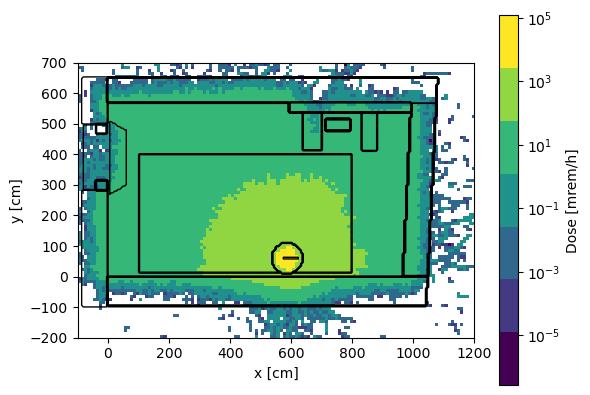

In [7]:
from openmc_regular_mesh_plotter import plot_mesh_tally

DT_neutron_generator = 2.60e+08  # n/s
pico_to_mrem = 1e-7
seconds_to_years = 60 * 60

mesh = openmc.RegularMesh()
mesh.dimension = (130, 90, 60)
mesh.lower_left = (-100.00, -200.00, -100.00)
mesh.upper_right = (1200.00, 700.00, 500.00)

scaling_factor = (DT_neutron_generator * pico_to_mrem * seconds_to_years) / mesh.volumes[0][0][0]

cmap = plt.get_cmap('viridis', 7)
cmap_stddev = plt.get_cmap('Reds', 7)
cmap_p = plt.get_cmap('plasma', 7)
plot = plot_mesh_tally(
        tally=neutron_tally_result,
        slice_index=19,
        basis="xy",
        geometry=geometry,
        outline=True,
        # score='flux', # only one tally so can make use of default here
        value="mean",
        colorbar_kwargs={
            'label': "Dose [mrem/h]",
        },
        norm=LogNorm(),
        volume_normalization=False,  # this is done in the scaling_factor
        scaling_factor=scaling_factor,
        cmap=cmap,
    )

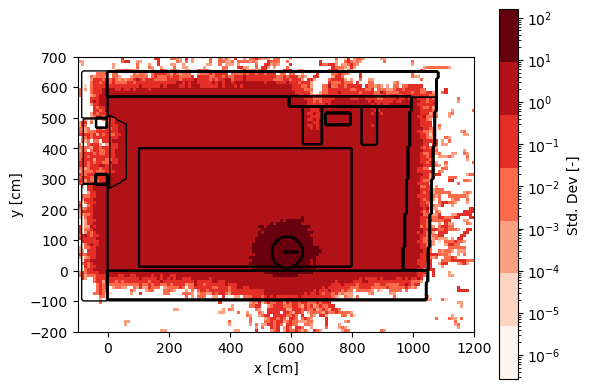

In [8]:
plot = plot_mesh_tally(
        tally=neutron_tally_result,
        slice_index=19,
        basis="xy",
        geometry=geometry,
        outline=True,
        # score='flux', # only one tally so can make use of default here
        value="std_dev",
        colorbar_kwargs={
            'label': "Std. Dev [-]",
        },
        norm=LogNorm(),
        volume_normalization=False,  # this is done in the scaling_factor
        scaling_factor=scaling_factor,
        cmap=cmap_stddev,
    )

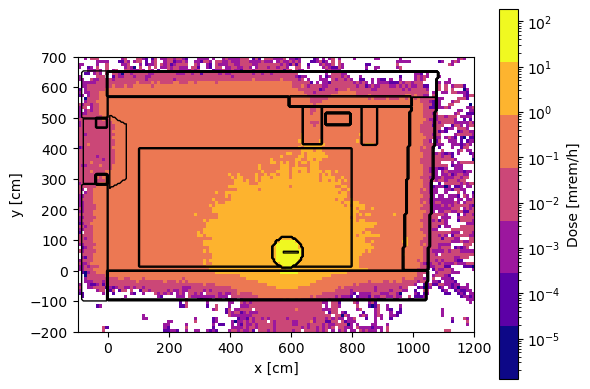

In [9]:
plot = plot_mesh_tally(
        tally=photon_tally_result,
        slice_index=19,
        basis="xy",
        geometry=geometry,
        outline=True,
        # score='flux', # only one tally so can make use of default here
        value="mean",
        colorbar_kwargs={
            'label': "Dose [mrem/h]",
        },
        norm=LogNorm(),
        volume_normalization=False,  # this is done in the scaling_factor
        scaling_factor=scaling_factor,
        cmap=cmap_p,
    )

In [ ]:
plot = plot_mesh_tally(
        tally=neutron_tally_result,
        slice_index=68,
        basis="yz",
        geometry=geometry,
        outline=True,
        # score='flux', # only one tally so can make use of default here
        value="mean",
        colorbar_kwargs={
            'label': "Dose [mrem/h]",
        },
        norm=LogNorm(),
        volume_normalization=False,  # this is done in the scaling_factor
        scaling_factor=scaling_factor,
    )

In [ ]:
plot = plot_mesh_tally(
        tally=neutron_tally_result,
        slice_index=25,
        basis="xz",
        geometry=geometry,
        outline=True,
        # score='flux', # only one tally so can make use of default here
        value="mean",
        colorbar_kwargs={
            'label': "Dose [µSv per year]",
        },
        norm=LogNorm(),
        volume_normalization=False,  # this is done in the scaling_factor
        scaling_factor=scaling_factor,
    )

## Zirconium Activation Foils

## Diamond Detector